In [3]:
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt
import json

from glob import glob
from collections import defaultdict

import grl_tools

In [4]:
# Load Serap's icetop GRL files
grl_base = '/data/ana/CosmicRay/IceTop_GRL'
grl_files = sorted(glob(f'{grl_base}/IC86_20*.txt'))

it_goodruns = []
for grl_file in grl_files:
    it_goodruns += grl_tools.parse_seraps_GRL(grl_file)

In [5]:
# Load information from i3live
start = '2012-05-13 00:00:00'
end   = '2022-05-13 00:00:00'
i3_goodruns = grl_tools.i3live_grl(start, end, icetop=True)

In [6]:
# Calculate livetimes for icetop
i3_livetime = grl_tools.daily_livetime(i3_goodruns, it_goodruns)

10.2% of runs filtered out by IT GRL


In [7]:
# We need the counts for each day in the IceTop maps. Load the output from count_finder.py
prefix = '/data/user/cjoiner/icetop_12yr/stability'
count_files = sorted(glob(f'{prefix}/counts_20??_Tier?.json'))

# Load count files into a single dictionary
counts = {}
for tier in range(1, 5):
    counts[tier] = {}
    tier_files = [f for f in count_files if f'Tier{tier}' in f]
    for tier_file in tier_files:        
        with open(tier_file, 'r') as f:
            counts_i = json.load(f)
        counts[tier].update(counts_i)

In [8]:
# dictionary for plotting histogram
livetimes = defaultdict(int)
for day in sorted(i3_livetime.keys()):
    for run, runtime in i3_livetime[day].items():
        livetimes[day] += runtime

In [9]:
# make a dictionary that gives the date and rate to use in histogram for each tier
daily_rates = {1: {}, 2: {}, 3:{}, 4:{}}
for tier in counts:
    for day in livetimes:
        if day not in counts[tier].keys() or livetimes[day]==0:
            continue
        daily_rates[tier][day] = counts[tier][day]/livetimes[day]
    #print(daily_rates.keys())
    #print(daily_rates.values())

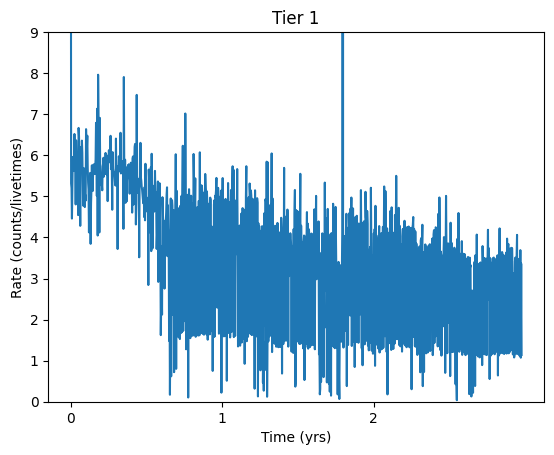

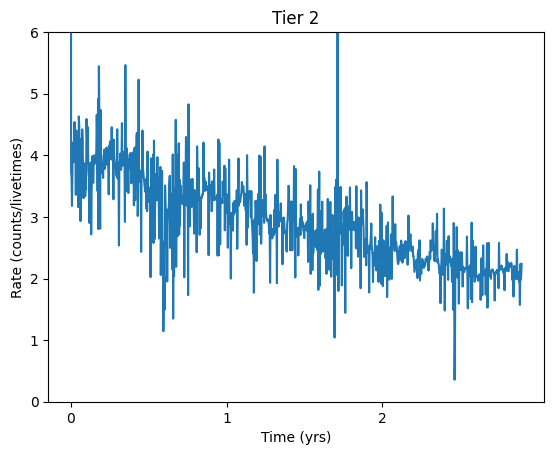

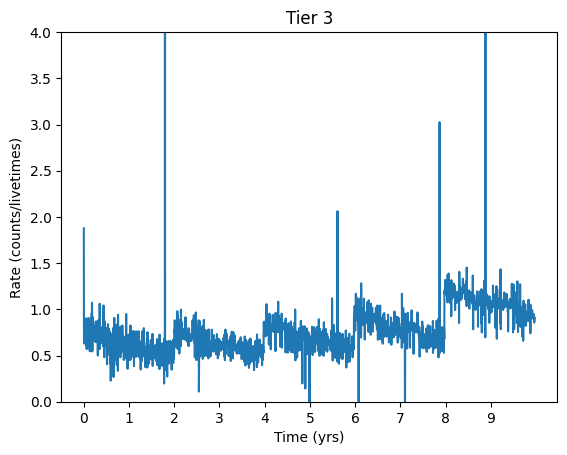

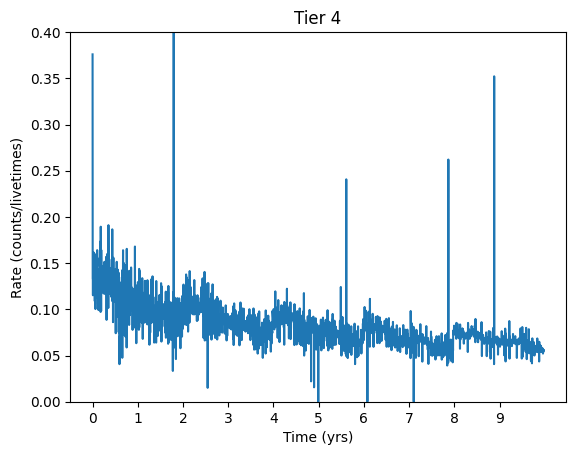

In [10]:
# make plot using daily_rates dictionary
range_dict = { 1: 9, 2: 6, 3: 4, 4: 0.4}
for tier in daily_rates:
    x = range(len(daily_rates[tier]))
    y = list(daily_rates[tier].values())
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(f"Tier {tier}")
    ax.set_ylim((0,range_dict[tier]))
    ticks = range(0, len(daily_rates[tier]), 365)
    ax.set_xticks(ticks, labels=list(range(len(ticks))))
    plt.xlabel("Time (yrs)")
    plt.ylabel("Rate (counts/livetimes)")
    plt.show()

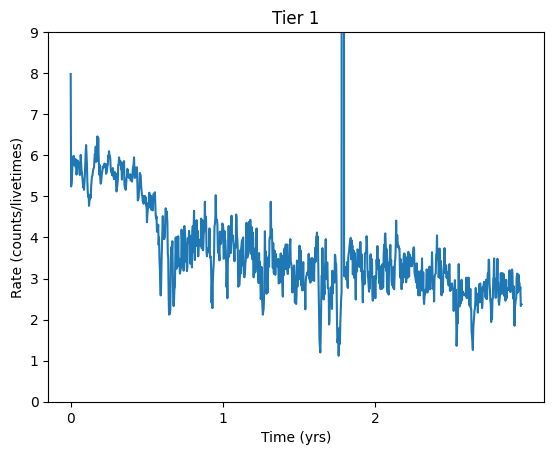

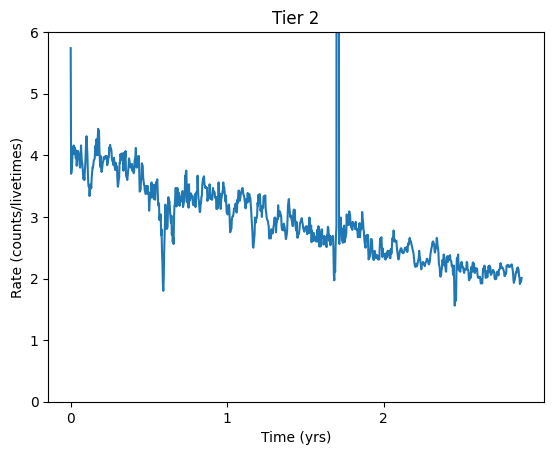

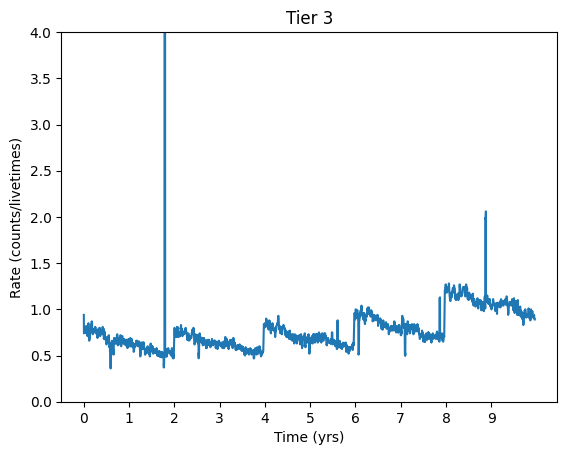

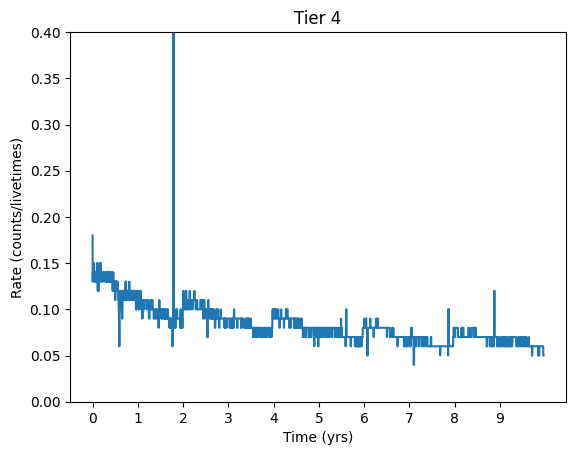

In [20]:
#plots with 5 day rolling average
range_dict = {1: 9, 2: 6, 3: 4, 4: 0.4}
window_size = 5
for tier in daily_rates:
    values = list(daily_rates[tier].values())
    # Compute moving average
    moving_averages = [
        round(float(sum(values[i:i + window_size])) / window_size, 2)
        for i in range(len(values) - window_size + 1)
    ]
    x = list(range(len(moving_averages)))
    y = moving_averages
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(f"Tier {tier}")
    ax.set_ylim((0,range_dict[tier]))
    ticks = range(0, len(daily_rates[tier]), 365)
    ax.set_xticks(ticks, labels=list(range(len(ticks))))
    plt.xlabel("Time (yrs)")
    plt.ylabel("Rate (counts/livetimes)")
    plt.show()

In [24]:
# Find the problem dates
dr = .9
bad_dates = []
for tier, rate_dict in daily_rates.items():

    if tier == 1:
        continue
    
    print(f'Tier {tier}:')
    all_rates = [rate for day, rate in rate_dict.items()]
    comp = np.median(all_rates[:7])

    for day, rate in rate_dict.items():

        # If we're outside our acceptable window
        if (rate >= (1+dr)*comp) or (rate <= (1-dr)*comp):
            if tier == 4:
                bad_dates.append(day)
            print(f'{day}: {rate:.03f} (vs rolling avg of {comp:.03f})')
            continue

        # Include good rates into rolling average
        comp = (4*comp + rate) / 5

    print()
print(bad_dates)

Tier 2:
2012-05-12: 14.420 (vs rolling avg of 3.730)
2014-02-28: 145.209 (vs rolling avg of 2.576)

Tier 3:
2012-05-12: 1.877 (vs rolling avg of 0.744)
2014-02-28: 27.788 (vs rolling avg of 0.491)
2017-05-18: 0.000 (vs rolling avg of 0.676)
2017-12-30: 2.061 (vs rolling avg of 0.596)
2018-06-19: 0.000 (vs rolling avg of 0.892)
2018-06-20: 0.000 (vs rolling avg of 0.892)
2019-06-28: 0.000 (vs rolling avg of 0.846)
2019-06-29: 0.000 (vs rolling avg of 0.846)
2020-04-03: 3.026 (vs rolling avg of 0.663)
2021-04-09: 5.974 (vs rolling avg of 1.012)

Tier 4:
2012-05-12: 0.376 (vs rolling avg of 0.134)
2014-02-28: 4.700 (vs rolling avg of 0.084)
2017-05-18: 0.000 (vs rolling avg of 0.077)
2017-12-30: 0.241 (vs rolling avg of 0.068)
2018-06-19: 0.000 (vs rolling avg of 0.078)
2018-06-20: 0.000 (vs rolling avg of 0.078)
2019-06-28: 0.000 (vs rolling avg of 0.071)
2019-06-29: 0.000 (vs rolling avg of 0.071)
2020-04-03: 0.262 (vs rolling avg of 0.055)
2021-04-09: 0.352 (vs rolling avg of 0.062)

[

In [31]:
for bad_day in bad_dates:
    print(f'Day {bad_day} livetime:')
    print(livetimes[bad_day])
    for tier in range(3,5):
        print(f'tier {tier} count:')
        print(counts[tier][bad_day])
#number of seconds in a day is 86400

Day 2012-05-12 livetime:
23709
tier 3 count:
44490
tier 4 count:
8913
Day 2014-02-28 livetime:
297
tier 3 count:
8253
tier 4 count:
1396
Day 2017-05-18 livetime:
85728
tier 3 count:
0
tier 4 count:
0
Day 2017-12-30 livetime:
10586
tier 3 count:
21819
tier 4 count:
2548
Day 2018-06-19 livetime:
86184
tier 3 count:
0
tier 4 count:
0
Day 2018-06-20 livetime:
84868
tier 3 count:
0
tier 4 count:
0
Day 2019-06-28 livetime:
85615
tier 3 count:
0
tier 4 count:
0
Day 2019-06-29 livetime:
86149
tier 3 count:
0
tier 4 count:
0
Day 2020-04-03 livetime:
3888
tier 3 count:
11765
tier 4 count:
1019
Day 2021-04-09 livetime:
5026
tier 3 count:
30026
tier 4 count:
1770


In [ ]:
'''
2012-05-12: small livetime
2014-02-28: small livetime and low count
2017-05-18: count of zero
2017-12-30: small livetime
2018-06-19: count of zero
2018-06-20: count of zero
2019-06-28: count of zero
2019-06-29: count of zero
2020-04-03: small livetime
2021-04-09: small livetime
'''